# Job Change of Data Scientists | Data Science Project | Data Preprocessing

> Data from [Kaggle](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists) with modification in problem context.

*This project was completed as a part of Rakamin Academy Data Science Bootcamp.*

Ascencio, a leading Data Science agency, offers training courses to companies to enhance their employees' skills. Companies want to predict which employees are **unlikely to seek a job change** after completing the course, as well as identify those who are **likely to finish it quickly**. By focusing on employees who are committed to staying and can contribute sooner, Ascencio helps companies optimize their training investments.

To achieve this, Ascencio will build two machine learning models: one to predict the training hours needed for an employee to complete the course, and another to predict whether an employee will seek a job change or not.

# Prepare Everything!

In [141]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# import classification models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier

# import feature importance
import shap
from sklearn.inspection import permutation_importance


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)


numpy version :  1.26.4
pandas version :  2.2.3


In [93]:
# read the data
df_train = pd.read_csv(r'Data/aug_train.csv')

# Data Preprocessing

## A. Feature Selection

Check that we will only use these columns as features<br/>
'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'

In [94]:
# drop column enrollee_id, city, and training_hours
print("df_train Dataframe")
df_train.drop(['enrollee_id','city','training_hours'], axis=1, inplace=True)
display(df_train.head())

df_train Dataframe


,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,0.0


## B. Feature Revision

We will rename and imputation data based on 1_EDA.ipynb analysis. We will set copy to dftr dataframe from df_train dataframe and dfte dataframe from df_test dataframe.

In [95]:
# feature revision for df_train
# rename relevent_experience to relevant_experience
df_train.rename(columns={'relevent_experience':'relevant_experience'}, inplace=True)

# copy the data
dftr = df_train.copy()

# change relevant_experience
dftr['relevant_experience'] = dftr['relevant_experience'].apply(lambda x: True if x == "Has relevent experience" 
                                                 else np.nan if pd.isna(x) else False)

# change enrolled_university
dftr['enrolled_university'] = dftr['enrolled_university'].apply(lambda x: "No Enroll" if x == "no_enrollment"
                                                                        else "Full Time" if x == "Full time course" 
                                                                        else np.nan if pd.isna(x) else "Part Time")

# imputation major_discipline
dftr['major_discipline'] = np.where((dftr['education_level'].isin(['Graduate', 'Masters'])) & (dftr['major_discipline'] == 'No Major'), np.nan, 
                        np.where((dftr['education_level'].isin(['Primary School', 'High School'])) & (dftr['major_discipline'].isnull()),'No Major',dftr['major_discipline']))

# grouping company_size
dftr['company_size'] = dftr['company_size'].apply(lambda x: '10-49' if x == '10/49' else x)

# rename company_type
dftr['company_type'] = dftr['company_type'].apply(lambda x: "Early Startup" if x == "Early Stage Startup" else x)

# check data
dftr.head(10)

,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.920,Male,True,No Enroll,Graduate,STEM,>20,NaN,NaN,1,1.0
1,0.776,Male,False,No Enroll,Graduate,STEM,15,50-99,Pvt Ltd,>4,0.0
2,0.624,NaN,False,Full Time,Graduate,STEM,5,NaN,NaN,never,0.0
3,0.789,NaN,False,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,1.0
4,0.767,Male,True,No Enroll,Masters,STEM,>20,50-99,Funded Startup,4,0.0
5,0.764,NaN,True,Part Time,Graduate,STEM,11,NaN,NaN,1,1.0
6,0.920,Male,True,No Enroll,High School,No Major,5,50-99,Funded Startup,1,0.0
7,0.762,Male,True,No Enroll,Graduate,STEM,13,<10,Pvt Ltd,>4,1.0
8,0.920,Male,True,No Enroll,Graduate,STEM,7,50-99,Pvt Ltd,1,1.0
9,0.920,NaN,True,No Enroll,Graduate,STEM,17,10000+,Pvt Ltd,>4,0.0


In [96]:
# drop rows with equal or more than 4 NaN values train data
print(f"Rows in dftr before is {dftr.shape[0]}")
dftr = dftr[dftr.isnull().sum(axis=1) < 4]
dftr.reset_index(inplace=True, drop=True)
print(f"Rows in dftr after is {dftr.shape[0]}")

Rows in dftr before is 19158
Rows in dftr after is 18628


## C. Type Data

In [97]:
# check type data of train data
print(dftr.info())
# relevant_experience have bool type since it only yes or no value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  18628 non-null  float64
 1   gender                  14487 non-null  object 
 2   relevant_experience     18628 non-null  bool   
 3   enrolled_university     18396 non-null  object 
 4   education_level         18481 non-null  object 
 5   major_discipline        18258 non-null  object 
 6   experience              18593 non-null  object 
 7   company_size            13190 non-null  object 
 8   company_type            12992 non-null  object 
 9   last_new_job            18392 non-null  object 
 10  target                  18628 non-null  float64
dtypes: bool(1), float64(2), object(8)
memory usage: 1.4+ MB
None


## D. Feature Encoding

In [98]:
# define ordered categories as lists
relevant_experience_cats = [False, True]
enrolled_university_cats = ['No Enroll', 'Part Time', 'Full Time']
education_level_cats = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
experience_cats = ['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
company_size_cats = ['<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
last_new_job_cats = ['never', '1', '2', '3', '4', '>4']
categories = [relevant_experience_cats, enrolled_university_cats, education_level_cats, experience_cats, company_size_cats, last_new_job_cats]

# define columns for ordinal encoding
cats_oe = ['relevant_experience', 'enrolled_university', 'education_level', 'experience', 'company_size', 'last_new_job']

# ordinal encoding
oe = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=np.nan)
dftr[cats_oe] = oe.fit_transform(dftr[cats_oe])
display(dftr.head(10))


,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.920,Male,1.0,0.0,2.0,STEM,21.0,NaN,NaN,1.0,1.0
1,0.776,Male,0.0,0.0,2.0,STEM,15.0,2.0,Pvt Ltd,5.0,0.0
2,0.624,NaN,0.0,2.0,2.0,STEM,5.0,NaN,NaN,0.0,0.0
3,0.789,NaN,0.0,NaN,2.0,Business Degree,0.0,NaN,Pvt Ltd,0.0,1.0
4,0.767,Male,1.0,0.0,3.0,STEM,21.0,2.0,Funded Startup,4.0,0.0
5,0.764,NaN,1.0,1.0,2.0,STEM,11.0,NaN,NaN,1.0,1.0
6,0.920,Male,1.0,0.0,1.0,No Major,5.0,2.0,Funded Startup,1.0,0.0
7,0.762,Male,1.0,0.0,2.0,STEM,13.0,0.0,Pvt Ltd,5.0,1.0
8,0.920,Male,1.0,0.0,2.0,STEM,7.0,2.0,Pvt Ltd,1.0,1.0
9,0.920,NaN,1.0,0.0,2.0,STEM,17.0,7.0,Pvt Ltd,5.0,0.0


In [99]:
# define column for one hot encoding
cats_ohe = ['gender','major_discipline','company_type']

# simple imputer nan to missing
si_miss = SimpleImputer(strategy='constant', fill_value='missing')
dftr[cats_ohe] = si_miss.fit_transform(dftr[cats_ohe])

# one hot encoding
ohe = OneHotEncoder(sparse_output=False)

ohe_dftr_array = ohe.fit_transform(dftr[cats_ohe])
ohe_dftr_name = ohe.get_feature_names_out(cats_ohe)
dftr = dftr.drop(cats_ohe, axis=1)
for i, col in enumerate(ohe_dftr_name):
    dftr[col] = ohe_dftr_array[:,i]
dftr.loc[dftr.gender_missing == 1, dftr.columns.str.startswith("gender_")] = np.nan
dftr.loc[dftr.major_discipline_missing == 1, dftr.columns.str.startswith("major_discipline_")] = np.nan
dftr.loc[dftr.company_type_missing == 1, dftr.columns.str.startswith("company_type_")] = np.nan
dftr.drop(columns=['gender_missing','gender_Other','major_discipline_missing','major_discipline_Other','company_type_missing','company_type_Other'], inplace=True)

In [100]:
display(dftr.head(10))

,city_development_index,relevant_experience,enrolled_university,education_level,experience,company_size,last_new_job,target,gender_Female,gender_Male,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_STEM,company_type_Early Startup,company_type_Funded Startup,company_type_NGO,company_type_Public Sector,company_type_Pvt Ltd
0,0.920,1.0,0.0,2.0,21.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
1,0.776,0.0,0.0,2.0,15.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.624,0.0,2.0,2.0,5.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,0.789,0.0,NaN,2.0,0.0,NaN,0.0,1.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.767,1.0,0.0,3.0,21.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.764,1.0,1.0,2.0,11.0,NaN,1.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
6,0.920,1.0,0.0,1.0,5.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.762,1.0,0.0,2.0,13.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.920,1.0,0.0,2.0,7.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,0.920,1.0,0.0,2.0,17.0,7.0,5.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## E. Handle Missing Value

We will using MICE to imputate missing data

In [101]:
# using linear regression to imputate missing value by MICE
lr = LinearRegression()
mice = IterativeImputer(estimator=lr, random_state=1, n_nearest_features=2, imputation_order='roman')
final_dftr = mice.fit_transform(dftr)
final_dftr = pd.DataFrame(final_dftr, columns=dftr.columns)

In [102]:
# check missing value
print(final_dftr.isnull().sum().sum())

0


## F. Split Data

In [103]:
# split data
X = final_dftr.drop('target', axis=1)
y = final_dftr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [104]:
# check data
print("Number of data points in train data :",X_train.shape)
print("Number of data points in validation data :",X_test.shape)

Number of data points in train data : (14902, 19)
Number of data points in validation data : (3726, 19)


## G. Sampling Data

In [105]:
# SMOTE
sm = SMOTE(random_state=1, sampling_strategy=0.35)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [106]:
# check imbalance data
print("Proportion of target in train data :",y_train.value_counts(normalize=True))

Proportion of target in train data : target
0.0    0.740765
1.0    0.259235
Name: proportion, dtype: float64


## H. Scaling Data

In [107]:
# standard scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## I. Machine Learning

In [137]:
# make metrics dataframe
def eval_model(model:list,fit:bool=True)->pd.DataFrame:
    # Initialize empty lists to store metrics
    name = []
    pr_auc_test = []
    pr_auc_train = []
    recall_test = []
    recall_train = []
    precision_test = []
    precision_train = []

    for m in model:
        if fit: # Check if model needs to be fitted
            m.fit(X_train, y_train)
        else:
            pass

        if hasattr(m, 'estimator'):
            a = str(type(m.estimator).__name__) + '_' + str(type(m).__name__)
            name.append(a)
        elif hasattr(m, '__name__'):
            a = str(m.__name__)
            name.append(a)
        else:
            a = str(type(m).__name__)
            name.append(a)
        
        # Append metrics to lists
        pr_auc_test.append(metrics.average_precision_score(y_test, m.predict(X_test)))
        pr_auc_train.append(metrics.average_precision_score(y_train, m.predict(X_train)))
        recall_test.append(metrics.recall_score(y_test, m.predict(X_test)))
        recall_train.append(metrics.recall_score(y_train, m.predict(X_train)))
        precision_test.append(metrics.precision_score(y_test, m.predict(X_test)))
        precision_train.append(metrics.precision_score(y_train, m.predict(X_train)))

    # Make a DataFrame with all metrics and differences
    df_sum = pd.DataFrame({'name': name,
                            'pr_auc_test': pr_auc_test,'pr_auc_train': pr_auc_train,
                            'recall_test': recall_test,'recall_train': recall_train,
                            'precision_test': precision_test,'precision_train': precision_train})
    
    df_sum['diff_pr_auc'] = df_sum['pr_auc_train'] - df_sum['pr_auc_test']
    df_sum['diff_recall'] = df_sum['recall_train'] - df_sum['recall_test']
    df_sum['diff_precision'] = df_sum['precision_train'] - df_sum['precision_test']

    return df_sum.sort_values(by='recall_test', ascending=False)

In [185]:
# make model explanation
def explain_model(model):
    # model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    if hasattr(model, 'estimator'):
        print(f'{type(model.estimator).__name__}_{type(model).__name__} Evaluation\n')
    elif hasattr(model, '__name__'):
        print(f'{model.__name__} Evaluation\n')
    else:
        print(f'{type(model).__name__} Evaluation\n')

    print(f'PR AUC (test): {metrics.average_precision_score(y_test, y_pred):.4f}')
    print(f'PR AUC (train): {metrics.average_precision_score(y_train, y_pred_train):.4f}')
    print(f'Diff PR AUC: {np.abs(metrics.average_precision_score(y_test, y_pred)-metrics.average_precision_score(y_train, y_pred_train)):.4f}\n')
    
    print(f'Recall (test): {metrics.recall_score(y_test, y_pred):.4f}')
    print(f'Recall (train): {metrics.recall_score(y_train, y_pred_train):.4f}')
    print(f'Diff Recall: {np.abs(metrics.recall_score(y_test, y_pred)-metrics.recall_score(y_train, y_pred_train)):.4f}\n')

    print(f'Precision (test): {metrics.precision_score(y_test, y_pred):.4f}')
    print(f'Precision (train): {metrics.precision_score(y_train, y_pred_train):.4f}')
    print(f'Diff Precision: {np.abs(metrics.precision_score(y_test, y_pred)-metrics.precision_score(y_train, y_pred_train)):.4f}\n')

    print('-'*100)

In [110]:
# ML models
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier(verbose=-1)
cat = CatBoostClassifier(verbose=False)

init_models = [lr, knn, dt, rf, ada, xgb, lgb, cat]

In [111]:
eval_model(init_models)

,name,pr_auc_test,pr_auc_train,recall_test,recall_train,precision_test,precision_train,diff_pr_auc,diff_recall,diff_precision
6,LGBMClassifier,0.704099,0.739906,0.755146,0.786643,0.852078,0.870276,0.035808,0.031497,0.018198
5,XGBClassifier,0.692227,0.794638,0.737811,0.819781,0.850187,0.912340,0.102411,0.081969,0.062153
7,CatBoostClassifier,0.702575,0.764561,0.737811,0.796839,0.864213,0.893398,0.061986,0.059028,0.029185
3,RandomForestClassifier,0.667644,0.961374,0.691224,0.965842,0.855228,0.986205,0.293730,0.274618,0.130977
2,DecisionTreeClassifier,0.563964,0.962705,0.685807,0.960235,0.708847,0.991838,0.398742,0.274427,0.282991
4,AdaBoostClassifier,0.517915,0.524184,0.551463,0.561050,0.737681,0.731472,0.006269,0.009588,-0.006209
1,KNeighborsClassifier,0.377141,0.543852,0.440953,0.602090,0.541223,0.731949,0.166711,0.161137,0.190726
0,LogisticRegression,0.332315,0.342929,0.248104,0.262554,0.588689,0.578002,0.010614,0.014450,-0.010687


Notes: Based on this result, we will using LGBMClassifier, XGBClassifier, and CatBoostClassifier to hyperparameter tuning

## J. Hyperparameter Tuning

### LGBMClassifier

#### Learning Curve

param value: 1; train pr auc: 0.7613346; test pr auc: 0.7160031; diff: 0.0453315


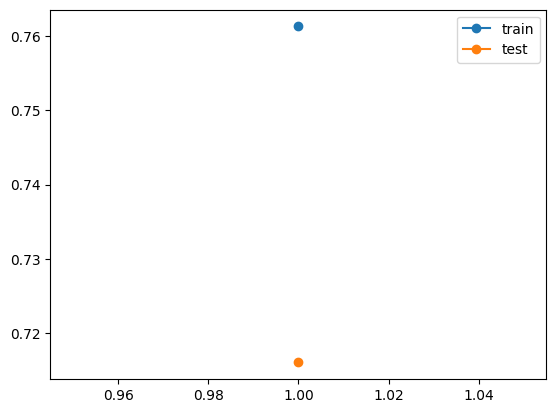

In [ ]:
param_values = [int(x) for x in np.linspace(195,205,10)] # max_bin = 198
param_values = [int(x) for x in np.linspace(90,110,20)] # num_iterations = 99
param_values = [float(x) for x in np.linspace(0.13,0.15,50)] # learning_rate = 0.14714
param_values = [int(x) for x in np.linspace(20,40,20)] # num_leaves = 31
param_values = [1]

train_scores = []
test_scores = []

for p in param_values:
  model = LGBMClassifier()
  model.set_params(max_bin=198,learning_rate=0.14714,num_iterations=99,num_leaves=31)
  model.fit(X_train, y_train)

  # eval di train data
  y_pred_train = model.predict(X_train)
  train_scores.append(metrics.average_precision_score(y_train, y_pred_train))

  # eval di test data
  y_pred = model.predict(X_test)
  test_scores.append(metrics.average_precision_score(y_test, y_pred))

  print(f"param value: {p}; train pr auc: {train_scores[-1]:.7f}; test pr auc: {test_scores[-1]:.7f}; diff: {train_scores[-1]-test_scores[-1]:.7f}")

plt.plot(param_values, train_scores, label='train', marker='o')
plt.plot(param_values, test_scores, label='test', marker='o')
plt.legend()
plt.show()

Based on Learning Curve, we get these best parameters:
- max_bin = 198
- num_iterations = 99
- learning_rate = 0.14714
- num_leaves = 31

In [186]:
# check using learning curve parameters
lclgbm = LGBMClassifier()
lclgbm.set_params(max_bin=198,learning_rate=0.14714,num_iterations=99,num_leaves=31)
lclgbm.__name__ = 'LGBMClassifier_LearningCurve'
lclgbm.fit(X_train, y_train, feature_name=X.columns.tolist())
explain_model(lclgbm)

LGBMClassifier_LearningCurve Evaluation

PR AUC (test): 0.7160
PR AUC (train): 0.7613
Diff PR AUC: 0.0453

Recall (test): 0.7638
Recall (train): 0.8035
Diff Recall: 0.0397

Precision (test): 0.8608
Precision (train): 0.8842
Diff Precision: 0.0233

----------------------------------------------------------------------------------------------------


#### Randomized Search CV

In [188]:
# hyperparameter
max_bin = [int(x) for x in np.linspace(195,205,10)] # max_bin = 198
num_iterations = [int(x) for x in np.linspace(90,110,20)] # num_iterations = 99
learning_rate = [float(x) for x in np.linspace(0.13,0.15,50)] # learning_rate = 0.14714
num_leaves = [int(x) for x in np.linspace(20,40,20)] # num_leaves = 31
hyperparameters = dict(max_bin=max_bin, num_iterations=num_iterations, learning_rate=learning_rate, num_leaves=num_leaves)

# Randomized Search CV
model = LGBMClassifier()
rslgbm = RandomizedSearchCV(model, hyperparameters, scoring='average_precision', cv=StratifiedKFold(n_splits=5), random_state=1, n_iter=100)
rslgbm.fit(X_train, y_train)
explain_model(rslgbm)

LGBMClassifier_RandomizedSearchCV Evaluation

PR AUC (test): 0.7041
PR AUC (train): 0.7622
Diff PR AUC: 0.0581

Recall (test): 0.7508
Recall (train): 0.8027
Diff Recall: 0.0519

Precision (test): 0.8556
Precision (train): 0.8858
Diff Precision: 0.0302

----------------------------------------------------------------------------------------------------


In [115]:
# check best parameters
rslgbm.best_params_

{'num_leaves': 33,
 'num_iterations': 101,
 'max_bin': 205,
 'learning_rate': 0.14061224489795918}

### XGBClassifier

#### Learning Curve

param value: 1; train pr auc: 0.7515471; test pr auc: 0.7001668; diff: 0.0513803


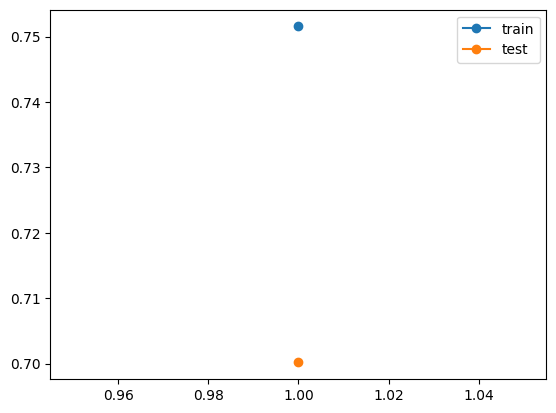

In [116]:
param_values = [int(x) for x in np.linspace(3,8)] # min_child_weight = 3 or 8
param_values = [float(x) for x in np.linspace(0.97,0.98,20)] # subsample = 0.9747368421052631
param_values = [float(x) for x in np.linspace(0,1,20)] # gamma = 0.6842105263157894
param_values = [float(x) for x in np.linspace(0.35,0.4,20)] # eta = 0.37894736842105264
param_values = [1]

train_scores = []
test_scores = []

for p in param_values:
  model = XGBClassifier()
  model.set_params(min_child_weight=3,subsample=0.9747368421052631,gamma=0.6842105263157894,eta=0.37894736842105264)
  model.fit(X_train, y_train)

  # eval di train data
  y_pred_train = model.predict(X_train)
  train_scores.append(metrics.average_precision_score(y_train, y_pred_train))

  # eval di test data
  y_pred = model.predict(X_test)
  test_scores.append(metrics.average_precision_score(y_test, y_pred))

  print(f"param value: {p}; train pr auc: {train_scores[-1]:.7f}; test pr auc: {test_scores[-1]:.7f}; diff: {train_scores[-1]-test_scores[-1]:.7f}")

plt.plot(param_values, train_scores, label='train', marker='o')
plt.plot(param_values, test_scores, label='test', marker='o')
plt.legend()
plt.show()

Based on Learning Curve, we get these best parameters:
- min_child_weight = 3
- subsample = 0.9747368421052631
- gamma = 0.6842105263157894
- eta = 0.37894736842105264

In [189]:
# check using learning curve parameters
lcxgb = XGBClassifier()
lcxgb.set_params(min_child_weight=3,subsample=0.9747368421052631,gamma=0.6842105263157894,eta=0.37894736842105264)
lcxgb.__name__ = 'XGBlcassifier_LearningCurve'
lcxgb.fit(X_train, y_train)
explain_model(lcxgb)

XGBlcassifier_LearningCurve Evaluation

PR AUC (test): 0.7002
PR AUC (train): 0.7515
Diff PR AUC: 0.0514

Recall (test): 0.7367
Recall (train): 0.7856
Diff Recall: 0.0489

Precision (test): 0.8619
Precision (train): 0.8859
Diff Precision: 0.0240

----------------------------------------------------------------------------------------------------


#### Randomized Search CV

In [118]:
# hyperparameter
min_child_weight = [int(x) for x in np.linspace(3,8)] # min_child_weight = 3 or 8
subsample = [float(x) for x in np.linspace(0.97,0.98,20)] # subsample = 0.9747368421052631
gamma = [float(x) for x in np.linspace(0,1,20)] # gamma = 0.6842105263157894
eta = [float(x) for x in np.linspace(0.35,0.4,20)] # eta = 0.37894736842105264
hyperparameters = dict(min_child_weight=min_child_weight, subsample=subsample, gamma=gamma, eta=eta)

# Randomized Search CV
model = XGBClassifier()
rsxgb = RandomizedSearchCV(model, hyperparameters, scoring='average_precision', cv=StratifiedKFold(n_splits=5), random_state=1, n_iter=100)
rsxgb.fit(X_train, y_train)
explain_model(rsxgb)

XGBClassifier_RandomizedSearchCV Evaluation

PR AUC (test): 0.6914
PR AUC (train): 0.7732
Diff PR AUC: 0.0818

Recall (test): 0.7335
Recall (train): 0.8022
Diff Recall: 0.0687

Precision (test): 0.8526
Precision (train): 0.8999
Diff Precision: 0.0473

----------------------------------------------------------------------------------------------------


In [119]:
# check best parameters
rsxgb.best_params_

{'subsample': 0.9789473684210526,
 'min_child_weight': 3,
 'gamma': 0.42105263157894735,
 'eta': 0.3657894736842105}

### CatBoostClassifier

#### Learning Curve

param value: 1; train pr auc: 0.7859463; test pr auc: 0.7178913; diff: 0.0680550


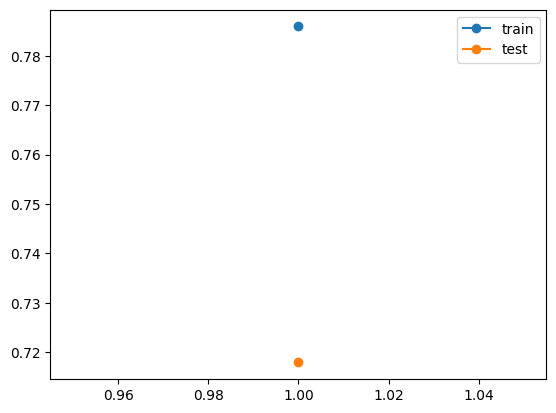

In [120]:
param_values = [float(x) for x in np.linspace(0.01,0.06,10)] # learning_rate = 0.03222222222222222
param_values = [int(x) for x in np.linspace(1,10,10)] # depth = 6
param_values = [float(x) for x in np.linspace(0.1,0.2,10)] # l2_leaf_reg = 0.15555555555555556
param_values = [1]

train_scores = []
test_scores = []

for p in param_values:
  model = CatBoostClassifier(verbose=False)
  model.set_params(learning_rate=0.03222222222222222, depth=6, l2_leaf_reg=0.15555555555555556)
  model.fit(X_train, y_train)

  # eval di train data
  y_pred_train = model.predict(X_train)
  train_scores.append(metrics.average_precision_score(y_train, y_pred_train))

  # eval di test data
  y_pred = model.predict(X_test)
  test_scores.append(metrics.average_precision_score(y_test, y_pred))

  print(f"param value: {p}; train pr auc: {train_scores[-1]:.7f}; test pr auc: {test_scores[-1]:.7f}; diff: {train_scores[-1]-test_scores[-1]:.7f}")

plt.plot(param_values, train_scores, label='train', marker='o')
plt.plot(param_values, test_scores, label='test', marker='o')
plt.legend()
plt.show()

In [190]:
# check using learning curve parameters
lccat = CatBoostClassifier(verbose=False)
lccat.set_params(learning_rate=0.03222222222222222, depth=6, l2_leaf_reg=0.15555555555555556)
lccat.__name__ = 'CatBoostlcassifier_LearningCurve'
lccat.fit(X_train, y_train)
explain_model(lccat)

CatBoostlcassifier_LearningCurve Evaluation

PR AUC (test): 0.7179
PR AUC (train): 0.7859
Diff PR AUC: 0.0681

Recall (test): 0.7497
Recall (train): 0.8160
Diff Recall: 0.0662

Precision (test): 0.8748
Precision (train): 0.9047
Diff Precision: 0.0299

----------------------------------------------------------------------------------------------------


#### Randomized Search CV

In [122]:
# hyperparameter
learning_rate = [float(x) for x in np.linspace(0.01,0.06,10)] # learning_rate = 0.03222222222222222
depth = [int(x) for x in np.linspace(1,10,10)] # depth = 6
l2_leaf_reg = [float(x) for x in np.linspace(0.1,0.2,10)] # l2_leaf_reg = 0.15555555555555556
hyperparameters = dict(learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg)

# Randomized Search CV
model = CatBoostClassifier(verbose=False)
rscat = RandomizedSearchCV(model, hyperparameters, scoring='average_precision', cv=StratifiedKFold(n_splits=5), random_state=1, n_iter=10)
rscat.fit(X_train, y_train)
explain_model(rscat)

CatBoostClassifier_RandomizedSearchCV Evaluation

PR AUC (test): 0.7052
PR AUC (train): 0.8309
Diff PR AUC: 0.1257

Recall (test): 0.7302
Recall (train): 0.8509
Diff Recall: 0.1207

Precision (test): 0.8742
Precision (train): 0.9311
Diff Precision: 0.0569

----------------------------------------------------------------------------------------------------


In [123]:
# check best parameters
rscat.best_params_

{'learning_rate': 0.03777777777777778,
 'l2_leaf_reg': 0.14444444444444446,
 'depth': 7}

## K. Ensemble Methods

### Stacking Classifier

In [124]:
# define level-1 algorithm
level1 = list()
level1.append(('lgbm', lclgbm))
level1.append(('cat', lccat))
level1.append(('xgb', lcxgb))

# define level-2 algorithm
level2 = lclgbm

# fit model
sc = StackingClassifier(estimators=level1, final_estimator=level2, cv=StratifiedKFold(n_splits=5))
sc.fit(X_train, y_train)
explain_model(sc)


StackingClassifier Evaluation

PR AUC (test): 0.7096
PR AUC (train): 0.7735
Diff PR AUC: 0.0639

Recall (test): 0.7638
Recall (train): 0.8144
Diff Recall: 0.0506

Precision (test): 0.8525
Precision (train): 0.8907
Diff Precision: 0.0382

----------------------------------------------------------------------------------------------------


### Voting Classifier

In [125]:
vc = VotingClassifier(estimators=level1, voting='soft')
vc.fit(X_train, y_train)
explain_model(vc)

VotingClassifier Evaluation

PR AUC (test): 0.7194
PR AUC (train): 0.7710
Diff PR AUC: 0.0517

Recall (test): 0.7562
Recall (train): 0.8063
Diff Recall: 0.0500

Precision (test): 0.8714
Precision (train): 0.8940
Diff Precision: 0.0226

----------------------------------------------------------------------------------------------------


## Summary

In [191]:
models = [lr,knn,dt,rf,ada,xgb,lgb,cat,lclgbm,lccat,lcxgb,rslgbm,rsxgb,rscat,sc,vc]

eval_model(models,fit=False)

,name,pr_auc_test,pr_auc_train,recall_test,recall_train,precision_test,precision_train,diff_pr_auc,diff_recall,diff_precision
8,LGBMClassifier_LearningCurve,0.716003,0.761335,0.763814,0.803467,0.860806,0.884151,0.045332,0.039653,0.023346
14,StackingClassifier,0.709643,0.773531,0.763814,0.814428,0.852479,0.890716,0.063888,0.050614,0.038238
15,VotingClassifier,0.719373,0.771034,0.756230,0.806271,0.871411,0.894008,0.051661,0.050041,0.022597
6,LGBMClassifier,0.704099,0.739906,0.755146,0.786643,0.852078,0.870276,0.035808,0.031497,0.018198
11,LGBMClassifier_RandomizedSearchCV,0.704090,0.762176,0.750813,0.802702,0.855556,0.885795,0.058085,0.051889,0.030239
9,CatBoostlcassifier_LearningCurve,0.717891,0.785946,0.749729,0.815957,0.874842,0.904748,0.068055,0.066228,0.029906
5,XGBClassifier,0.692227,0.794638,0.737811,0.819781,0.850187,0.912340,0.102411,0.081969,0.062153
7,CatBoostClassifier,0.702575,0.764561,0.737811,0.796839,0.864213,0.893398,0.061986,0.059028,0.029185
10,XGBlcassifier_LearningCurve,0.700167,0.751547,0.736728,0.785623,0.861850,0.885887,0.051380,0.048895,0.024036
12,XGBClassifier_RandomizedSearchCV,0.691419,0.773183,0.733478,0.802192,0.852645,0.899914,0.081764,0.068714,0.047269


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

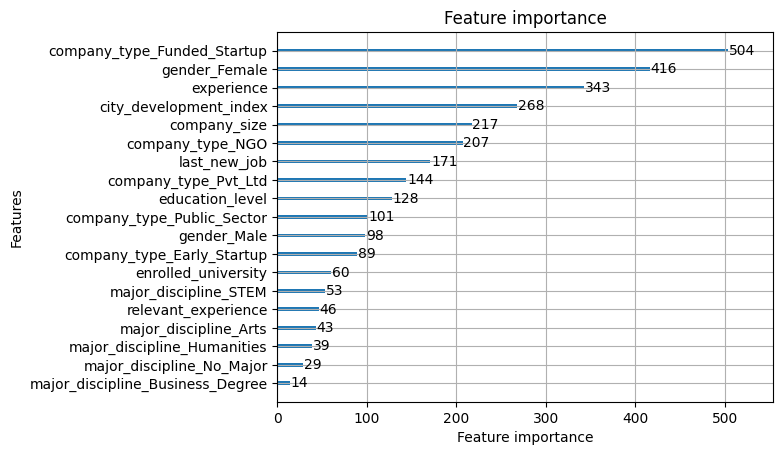

In [192]:
plot_importance(lclgbm)

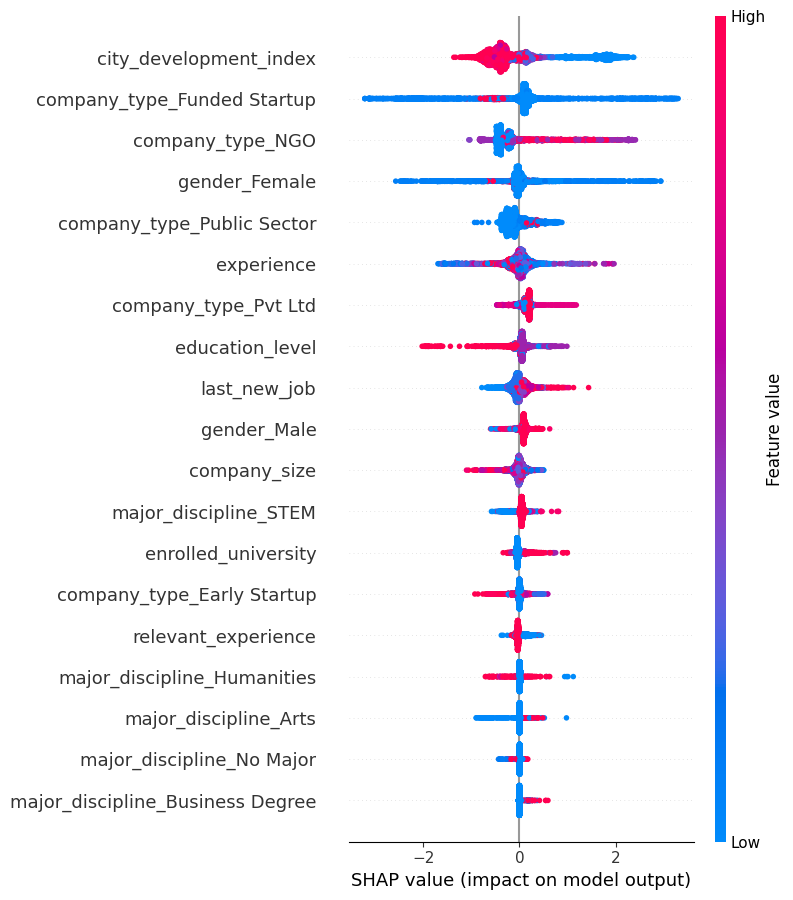

In [197]:
# shap
explainer = shap.TreeExplainer(lclgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist())

In [219]:
coba = pd.DataFrame(X_train, columns=X.columns.tolist())
coba['target'] = y_train
coba

,city_development_index,relevant_experience,enrolled_university,education_level,experience,company_size,last_new_job,gender_Female,gender_Male,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_STEM,company_type_Early Startup,company_type_Funded Startup,company_type_NGO,company_type_Public Sector,company_type_Pvt Ltd,target
0,0.942116,1.0,0.000000,0.50,0.476190,0.428571,1.000000,0.000000,1.000000,0.004753,1.000000,0.025481,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
1,0.582834,1.0,1.000000,0.50,0.523810,0.142857,0.000000,1.000000,0.000000,0.004753,0.015588,0.025481,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
2,0.898204,1.0,0.000000,0.75,0.428571,0.285714,0.200000,0.000000,1.000000,0.004753,0.015588,0.025481,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
3,0.942116,1.0,0.000000,0.50,0.523810,0.142857,0.200000,0.000000,1.000000,0.004753,0.015588,0.025481,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
4,0.626747,1.0,0.037377,1.00,0.714286,0.000000,1.000000,0.000000,1.000000,0.004753,0.015588,0.025481,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15128,0.944607,1.0,0.000000,0.75,0.456379,1.000000,1.000000,0.037024,0.959158,0.004753,0.015588,0.025481,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
15129,0.603269,1.0,0.000000,0.50,0.476190,1.000000,0.200000,0.000000,1.000000,0.004753,0.015588,0.025481,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
15130,0.351297,1.0,1.000000,0.50,0.095238,0.194431,0.182963,0.084036,0.901943,0.004753,0.015588,0.025481,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
15131,0.624463,1.0,0.000000,0.50,0.238095,0.440045,0.200000,0.000000,1.000000,0.004753,0.015588,0.025481,0.0,1.0,0.052094,0.077134,0.034643,0.065341,0.774512,1.0


(-0.5, 1.5)

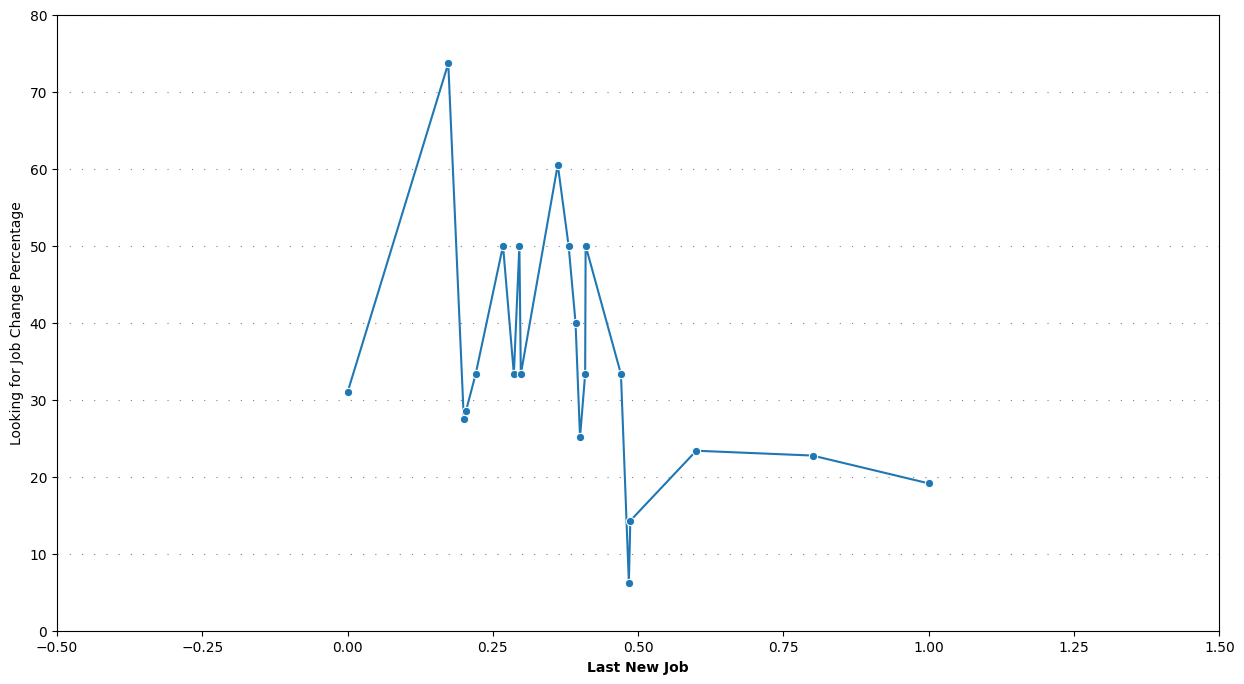

In [221]:
import seaborn as sns
#  lineplot for internal of employee part 1
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.15, hspace=0.005)

ax0 = fig.add_subplot(gs[:,:])

# ax0 - Gender
ds = coba[['last_new_job','target']].pivot_table(index='last_new_job', columns='target', aggfunc=len).reset_index().rename(columns={0.0:'Not Looking for Job Change', 1.0:'Looking for Job Change'})
ds['Total'] = ds['Looking for Job Change'] + ds['Not Looking for Job Change']
ds['Looking for Job Change Percentage'] = ds['Looking for Job Change'] / ds['Total'] * 100
# ds = ds.set_index('last_new_job').loc[['Male','Female','Other']].reset_index()

ax0 = sns.lineplot(data=ds, x='last_new_job', y='Looking for Job Change Percentage', marker='o', ax=ax0)
ax0.grid(color='gray', ls=':', axis='y', zorder=0, dashes=(1,10))

ax0.set_xlabel('Last New Job', size=10, weight='bold')
ax0.set_ylabel('Looking for Job Change Percentage')
ax0.set_ylim(0,80)
ax0.set_xlim(-0.5,1.5)